Across many areas of science, sparsity is ubiquitous. Whether in the form of sparse data arrays, sparse linear operators, or the results from a sparsity-promoting optimization, sparse vectors, matrices, and tensors are common place in scientific computing. Sparse data structures, by definition, consist mostly of the same repeated value, typically zero. This feature can be exploited so as to reduce storage and runtime; sparse data is highly compressible because we can get away with only storing the nonzero values. There are many ways to store the nonzeros of a sparse data structure, which are manifested in many different sparse storage formats and are effecient at different kinds of operations. For example, a hashmap is well-suited for storing pairs of indices and their corresponding nonzero values and allows for efficient writing and mutating, but is poorly-suited for mathematical operations. By contrast, the compressed sparse row (CSR) storage format is well-suited for fast mathematical operations and compresses nicely but offers extremely inefficient writing and mutating capabilities.  

In the scientific Python ecosystem, scipy.sparse has long been the de-facto sparse data module. It includes a full suite of sparse matrix formats and includes sparse linear system and eigen solvers. Additionaly, libraries that utilize sparse data such as scikit-learn relie on scipy.sparse. While being a mature and fast codebase, scipy.sparse emulates the numpy.matrix interface, which is restricted to two dimensions and is pending deprecation. As a result, scipy.sparse doesn't work well in places that numpy.ndarray does and it doesn't play nicely with the many libraries that emulate the numpy.ndarray interface such as dask and xarray. Since some of these libraries play important roles in scaling out the scientific Python ecosystem to larger data and distributed computing platforms, the reliance on the numpy.matrix interface holds scipy.sparse back.

In efforts to address these concerns, the pydata/sparse library implements n-dimensional sparse data structures that emulate the numpy.ndarray interface. Pydata/sparse does this by extending two sparse matrix formats: the dictionary of keys (DOK) and the coordinate (COO) formats. DOK utilizes a hashmap to store the indices and values and is used mostly for writing. COO uses an array (ndim, nnz) to store the nonzero coordinates of each dimension and a seperate array to store the nonzero values. It implements element-wise operations, reductions, dot and tensordot operations, and is compatible with xarray and dask. The COO format, while fundamental, has several shortcomings in the way of compression and interoperability with the current users of scipy.sparse. Regarding compression, since COO stores a coordinate for each dimension of an array along with the nonzeros, as the number of dimensions increases, the storage requirements can quickly become unfavorable (O(ndim * nnz)). Also, most of the functions written inside scikit-learn and elsewhere work with compressed sparse row/column (CSR/CSC) matrices, not COO.

With these issues in mind, pydata/sparse recently released the GCXS format. GCXS is an n-dimensional generalization of CSR/CSC. A main feature of it is that 2-d GCXS arrays are identical to CSR/CSC matrices (depending on which axis is compressed). This makes it so that libraries that use the CSR/CSC model internally can easily be modified to work with GCXS arrays. GCXS is also capable of a high degree of compression.

Understanding how GCXS works requires first understanding how the CSR/CSC model works for matrices. For a CSR matrix, we store three arrays: the nonzero data, the indices corresponding the columns of each of the each the nonzero data, and an array of integers that point to where each row begins in the indices array.


In [1]:
import sparse
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.sparse as ss
from nilearn import plotting as plt
import warnings
warnings.filterwarnings('ignore')

Here we make a 5x5 CSR matrix

In [2]:
a = sparse.random((5,5), density=.2, format='gcxs')

In [3]:
a

Format,gcxs
Data Type,float64
Shape,"(5, 5)"
nnz,5
Density,0.2
Read-only,True
Size,128
Storage ratio,0.6
Compressed Axes,"(0,)"


In [4]:
a.todense()

array([[0.25710831, 0.        , 0.56822   , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.54305051, 0.        ],
       [0.        , 0.37660311, 0.        , 0.        , 0.75337383],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

As we can see, the data is sorted in row-major ordering:

In [5]:
a.data

array([0.25710831, 0.56822   , 0.54305051, 0.37660311, 0.75337383])

The indices store which columns have nonzeros:

In [6]:
a.indices

array([0, 2, 3, 1, 4])

The index pointer array tells us which rows are paired with the columns in 'indices'

In [7]:
a.indptr

array([0, 2, 3, 5, 5, 5])

The columns stored in 'indices' for the i-th row correspond to a.indices[a.indptr[i]:a.indptr[i+1]]

In [8]:
for i in range(5):
    print("The nonzero columns of row %s " %(i), a.indices[a.indptr[i]:a.indptr[i+1]])

The nonzero columns of row 0  [0 2]
The nonzero columns of row 1  [3]
The nonzero columns of row 2  [1 4]
The nonzero columns of row 3  []
The nonzero columns of row 4  []


The CSC data structure uses the same idea but stores the data in column-major ordering:

In [9]:
b = a.change_compressed_axes([1])
b

Format,gcxs
Data Type,float64
Shape,"(5, 5)"
nnz,5
Density,0.2
Read-only,True
Size,128
Storage ratio,0.6
Compressed Axes,"(1,)"


In [10]:
b.todense()

array([[0.25710831, 0.        , 0.56822   , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.54305051, 0.        ],
       [0.        , 0.37660311, 0.        , 0.        , 0.75337383],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

Now the data is sorted in column-major form:

In [11]:
b.data

array([0.25710831, 0.37660311, 0.56822   , 0.54305051, 0.75337383])

The 'indices' array now stores the rows of the nonzero values:

In [12]:
b.indices

array([0, 2, 0, 1, 2])

And now the index pointer array tells us which of the rows in 'indices' correspond to what column:

In [13]:
b.indptr

array([0, 1, 2, 3, 4, 5])

In [14]:
for i in range(5):
    print("The nonzero rows of column %s " %(i), b.indices[b.indptr[i]:b.indptr[i+1]])

The nonzero rows of column 0  [0]
The nonzero rows of column 1  [2]
The nonzero rows of column 2  [0]
The nonzero rows of column 3  [1]
The nonzero rows of column 4  [2]


For GCXS, CSR and CSC can be thought of as the same data structure, but with a different compressed axis. For CSR the first axis (rows) are compressed whereas for CSC the second axis (columns) are compressed.

In [15]:
a.compressed_axes

(0,)

In [16]:
b.compressed_axes

(1,)

The way we can work with arrays of higher dimensions using this kind of scheme is by transposing axes and reshaping the original array into a two-dimensional array and applying the same methods. We transpose the axes to put the compressed axes first and the reshape the array to two dimensions with the resulting shape: (product of compressed axes, product of uncompressed axes). For a 3x4x5 array, if we compress the first axis then we will store a CSR matrix with a shape of (3, 4x5=20).

In [17]:
x = sparse.random((3,4,5), density=.2, format='gcxs')

In [18]:
x._compressed_shape

(3, 20)

If we compress the second axis, then we transpose the array and reshape it into a (4, 3x5=15) matrix.

In [19]:
x.change_compressed_axes([1])._compressed_shape

(4, 15)

We can also compress multiple axes:

In [20]:
x.change_compressed_axes([0,2])._compressed_shape

(15, 4)

Different choices in compressed axes affects the degree of compression and the speed of certain operations, especially indexing. Like CSR/CSC, the storage demands are determined by the size of the compressed axes and the number of nonzeros. Because the storage demands of a GCXS array are not dependent on the number of dimensions of the array, GCXS compresses well even with high dimensional arrays. The best compression is achieved by compressing the smallest axis:

In [21]:
y = sparse.random((5,20,35,50), density=.15, format='gcxs')
axes = ([0], [1], [2], [3], [0,1], 
        [0,2], [0,3], [1,2], 
        [1,3], [2,3], [0,1,2],
        [0,2,3], [1,2,3])
percent_stored = []
shapes = []
for axis in axes:
    y = y.change_compressed_axes(axis)
    percent_stored.append(y.nbytes/(np.prod(y.shape)*y.dtype.itemsize) *100)
    shapes.append(y._compressed_shape)
    #print('compressed axes: %s compression ratio: %s ' %(axis, y.nbytes/(np.prod(y.shape)*y.dtype.itemsize) *100),
     #        'shape of underlying matrix: ', y._compressed_shape)
df = pd.DataFrame()
df['compressed_axes'] = axes
df['percent_compression'] = percent_stored
df['compressed_shape'] = shapes
df

,compressed_axes,percent_compression,compressed_shape
0,[0],30.003429,"(5, 35000)"
1,[1],30.012000,"(20, 8750)"
2,[2],30.020571,"(35, 5000)"
3,[3],30.029143,"(50, 3500)"
4,"[0, 1]",30.057714,"(100, 1750)"
5,"[0, 2]",30.100571,"(175, 1000)"
6,"[0, 3]",30.143429,"(250, 700)"
7,"[1, 2]",30.400571,"(700, 250)"
8,"[1, 3]",30.572000,"(1000, 175)"
9,"[2, 3]",31.000571,"(1750, 100)"


As we can see, compressing the three largest axes together gets the worst compression. Nonetheless, in this example the worst compression still results in storing only half of the bytes needed for the equivelant dense array. Also, with this number of dimensions, the compression will usually be much better than COO:

In [22]:
y.tocoo().nbytes/(np.prod(y.shape)*y.dtype.itemsize) *100

75.0

GCXS arrays compress well and look and behave like NumPy arrays. GCXS currently supports the following operations:
 - indexing
 - multiplication
     - dot
     - tensordot
     - matmul
 - element-wise operations (including broadcasting)
     - np.sin
     - np.sqrt
     - np.add
     - np.log
     - ...
 - reductions
     - min
     - max
     - sum
     - prod
     - mean
     - std
     - var
     - ...

# Example: Neuroimaging

Neuroimaging is an interesting use case for sparse arrays. MRI data is collected in a 3-dimensional grid and is often transformed into a standard space. The standard Montreal Neurological Institute space (MNI152) has the dimensions (91, 109, 91). A brain in this space, however,  typically occupies only a third of the full space, with the remainder of the array filled with zeros. When working with more dimensions like time or subjects, these datasets can get quite large and be computationally expensive. Sparse arrays work well with this kind of data.  

One common need in a diffusion-weighted imaging analysis is to separate the white matter from the gray matter so that we can further examine the white matter. The goal is to define a white matter mask that we can use on all of our subjects. One simple way to do this is to take the mean accross subjects and threshold the data. When we are working with fractional anisotropy values (FA), the white matter and gray matter naturally seperate with higher values in the white matter. Since we are interested in computing across subjects it makes sense to compress the subjects dimension and group all of the spatial dimensions together. 

Here is a dataset with sixteen subjects:

In [23]:
img = nib.load('test_FA.nii.gz')

In [24]:
data = sparse._compressed.GCXS.from_numpy(img.get_data(), compressed_axes=[3])

As a quick data check, let's have a look at the FA values of our first subjects' brain.

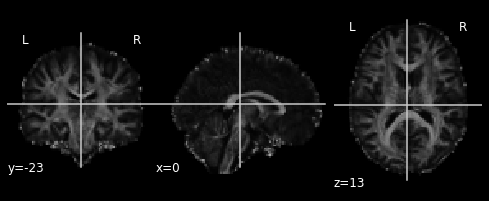

In [25]:
plt.plot_anat(img.slicer[...,0])

As we can see, the data compresses pretty well:

In [26]:
data

Format,gcxs
Data Type,float64
Shape,"(91, 109, 91, 16)"
nnz,4597231
Density,0.31832229797624495
Read-only,True
Size,70.1M
Storage ratio,0.6
Compressed Axes,"(3,)"


Just like if this were a NumPy array, we can take the mean along the third axis, corresponding to subjects:

In [27]:
mean = data.mean(axis=3)

Now we can project the mean back onto a brain for visualization.

In [28]:
header = img.header
header['cal_min'] = mean.min()
header['cal_max'] = mean.max()

In [29]:
mean_dense = mean.todense()

In [30]:
mean_img = nib.Nifti1Image(mean_dense, header=header, affine=img.affine)

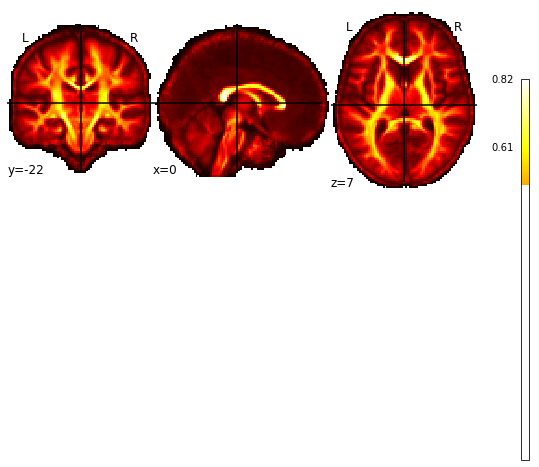

In [31]:
plt.plot_stat_map(mean_img)

The white matter comes out very bright. We can threshold the data to fully separate the white matter from the gray.

In [32]:
mean_dense[mean_dense < .2] = 0

In [33]:
mean_img = nib.Nifti1Image(mean_dense, header=header, affine=img.affine)

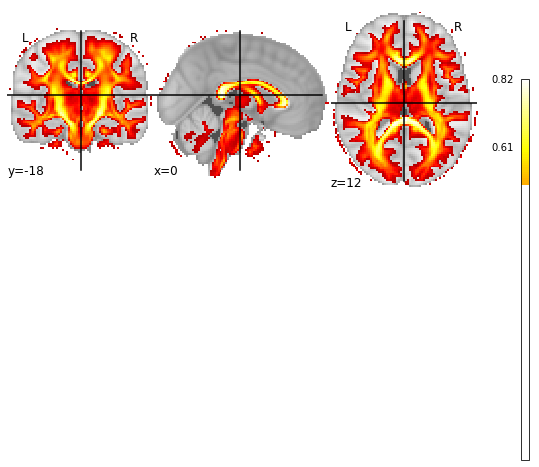

In [34]:
plt.plot_stat_map(mean_img)

# Scipy Integration

The linear algebra routines inside Scipy work with Pydata/sparse arrays. The sparse SVD is of utmost importance in a large number of data analytic applications. Using pydata/sparse arrays alongside Scipy makes this procedure pretty easy. Similar to generating "eigen faces," with the SVD we can look at the low-rank structure of our data and visualize "eigen brains," possibly to denoise the data or examine structure, but mostly for fun. First, we have to reshape our array into a matrix (spatial-dimensions-by-subjects). Fortunately, we're already storing the array as a matrix with these dimensions (swapped):    

In [35]:
data._compressed_shape

(16, 902629)

All we need to do is make a new array from the pieces of what we already have and replace the shape:

In [36]:
folded = sparse._compressed.GCXS((data.data, data.indices, data.indptr),
                                shape=data._compressed_shape[::-1], compressed_axes=[1])

In [37]:
folded

Format,gcxs
Data Type,float64
Shape,"(902629, 16)"
nnz,4597231
Density,0.31832229797624495
Read-only,True
Size,70.1M
Storage ratio,0.6
Compressed Axes,"(1,)"


Now we can apply the SVD.


In [38]:
u, s, vt = ss.linalg.svds(folded, 15)

The columns of 'u' hold the dominant spatial patterns of the data. We can reshape these vectors and project them onto brains:

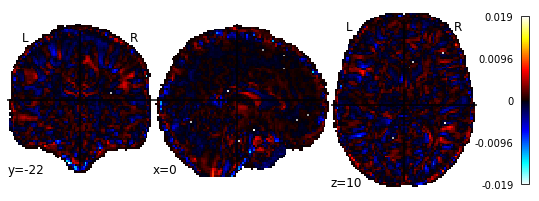

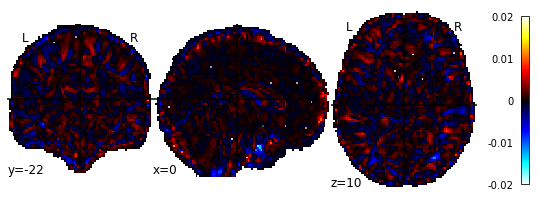

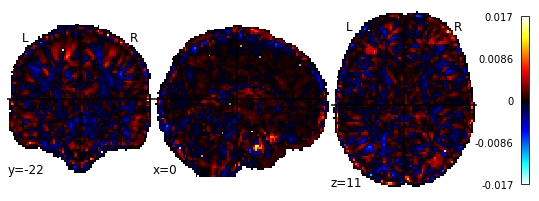

In [39]:
for i in range(3):
    u_vec = u[:,i].reshape((91,109,91))
    header['cal_min'] = u_vec.min()
    header['cal_max'] = u_vec.max()
    eigen_brain = nib.Nifti1Image(u_vec, header=header, affine=img.affine)
    plt.plot_stat_map(eigen_brain)

While yet readily interpretable, there is some clear structure in these different spatial modes.

# Conclusion

Problems involving sparsity are pervasive in scientific computing. Efficiently storing and manipulating large sparse arrays requires thoughtful storage formats. In an ecosystem where more and more libraries emulate and interact with NumPy, it's important that sparse arrays be compatable, especially with libraries like Dask, for predictablity of behavior and scalability. Pydata/sparse arrays offer these features. Each storage format offers different advantages. Because GCXS is identical to CSR/CSC for two-dimensional arrays, it is primed to work effectively in all the libraries that expect CSR/CSC. It also excels in the same areas as CSR/CSC; namely in fast matrix multiplication. Above and beyond this, GCXS offers good compression for high-dimensional arrays.